# Нейронные сети








# Метод обратного распространения ошибки

Обучение нелинейного нейрона.  Проблема обучения нелинейного нейрона в скрытом слое состоит в том, что для адаптации параметров нейрона нужно знать ошибку на выходе нейрона.

Последовательность перехода сигнала определяется конструкцией нейрона и характеристикой, которую обеспечивает активационная функция.  



In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.datasets import load_digits
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

##  Проблемы обучения нелинейного нейрона

Нейрон для анализа - логистического типа. Определим основные функции для обработки:

- to_one_hot(Y) : преобразует значение в вектор по правилу one-hot-encoding ( пример при 10 классах, значение Y=4 переведем в вектор <0, 0, 0, 0, 1, 0, 0, 0, 0, 0 >),

- from_one_hot(Y) : переводит вектор one-hot-encoding в значение скалярного типа (вектор Y <0, 0, 0, 0, 1, 0, 0, 0, 0, 0 > переводится в значение 4)

- sum_neuron(x=None, w=None) : вернет свертку векторов x, w - на выходе скалярное значение - внутреннее состояние нейрона,

-  sigmoid_complex_neuron(x = None, w = None, bias=0, lymbd = 1) : логистический нейрон с входным набором значений х  и настраиваемыми параметрами w.

- sigmoid_deriv(g) : производная логистического нейрона,

- normalize(X, axis=-1, order=2) : нормализация признаков - делаем входы удобными для нейрона

### **Задание 1**

1.1 реализовать функции to_one_hot(Y), from_one_hot(Y), sum_neuron(x=None, w=None), sigmoid_complex_neuron(x = None, w = None, bias=0, lymbd = 1), sigmoid_deriv(g), normalize(X, axis=-1, order=2)

1.2 визуализировать результат работы sigmoid_complex_neuron(x = None, w = None, bias=0, lymbd = 1), sigmoid_deriv(g)

In [20]:
# 1.1
def to_one_hot(y):
    classes = y.max() + 1
    y_one_hot = np.eye(classes, dtype=int)
    return y_one_hot[y]

def from_one_hot(y):
    return np.argmax(y, axis=1)

def sum_neuron(x=None, w=None):
    return x @ w

def sigmoid_complex_neuron(x=None, w=None, bias=0, lymbd=1):
    z = sum_neuron(x, w) + bias
    return 1. / (1 + np.exp(-lymbd * z))

def sigmoid_deriv(z):
    return z * (1 - z)

def normalize(X, axis=-1, order=2):
    norm = np.linalg.norm(X, order, axis, keepdims=True)
    norm = np.where(norm == 0, 1, norm) 
    return X / norm

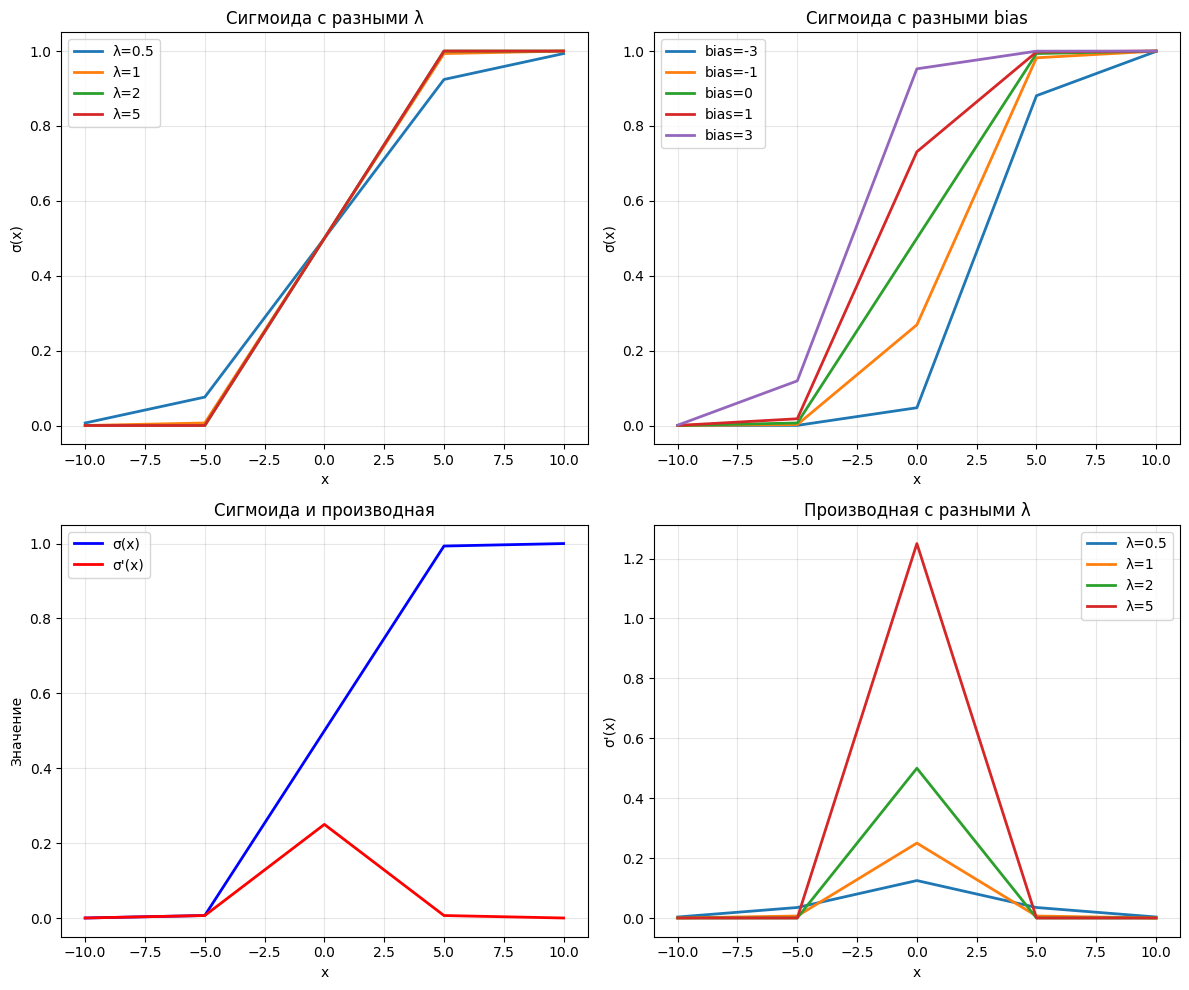

In [22]:
# 1.2
x_range = np.linspace(-10, 10, 5)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

ax1 = axes[0, 0]
for lymbd in [0.5, 1, 2, 5]:
    y = [sigmoid_complex_neuron(np.array([x]), np.array([1]), 0, lymbd) for x in x_range]
    ax1.plot(x_range, y, label=f'λ={lymbd}', linewidth=2)
ax1.set_xlabel('x')
ax1.set_ylabel('σ(x)')
ax1.set_title('Сигмоида с разными λ')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
for bias in [-3, -1, 0, 1, 3]:
    y = [sigmoid_complex_neuron(np.array([x]), np.array([1]), bias, 1) for x in x_range]
    ax2.plot(x_range, y, label=f'bias={bias}', linewidth=2)
ax2.set_xlabel('x')
ax2.set_ylabel('σ(x)')
ax2.set_title('Сигмоида с разными bias')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
y_sigmoid = [sigmoid_complex_neuron(np.array([x]), np.array([1]), 0, 1) for x in x_range]
y_deriv = [sigmoid_deriv(y) for y in y_sigmoid]
ax3.plot(x_range, y_sigmoid, label='σ(x)', linewidth=2, color='blue')
ax3.plot(x_range, y_deriv, label="σ'(x)", linewidth=2, color='red')
ax3.set_xlabel('x')
ax3.set_ylabel('Значение')
ax3.set_title('Сигмоида и производная')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
for lymbd in [0.5, 1, 2, 5]:
    y_sigmoid = [sigmoid_complex_neuron(np.array([x]), np.array([1]), 0, lymbd) for x in x_range]
    y_deriv = [sigmoid_deriv(y) * lymbd for y in y_sigmoid]
    ax4.plot(x_range, y_deriv, label=f'λ={lymbd}', linewidth=2)
ax4.set_xlabel('x')
ax4.set_ylabel("σ'(x)")
ax4.set_title('Производная с разными λ')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Обратное распространение ошибки:**

1. описание модели и данных: число эпох, веса, скорость обучения, разделение данных на тест, валидацию и тренировку

2. Подготовка тренировочных данных

3. Обученние нейронной сети

3.1. прямое распространение(feed forward)

3.2. оценка ошибки на выходе

3.3.1 получение значения производной активационнной функции текущего слоя

3.3.2 получение оценки ошибки на выходе предшествующего слоя

3.3.3 коррекция весов текущего слоя

3.3.4 переход к предшествующему слою если он не является рецептивным , иначе конец шага 3.3

3.4 проверка числа эпох: если необходимое число эпох отработано, то конец шага 3., иначе вернуться к 3.1.

4. Оценка результатов на тестовом множестве



### **Задание 2**

2.1. Реализовать цикл работы для обучения модели по оратному распространению ошибки на примере ирисов Фишера

2.2. визуализировать результаты

In [33]:
### Шаг 2. Подготовка тренировочных данных
# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
data = load_iris()

# формирование входных данных

x = data['data']
x = normalize(x)

# формирование выходных данных(результатов)

y = data['target']

y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

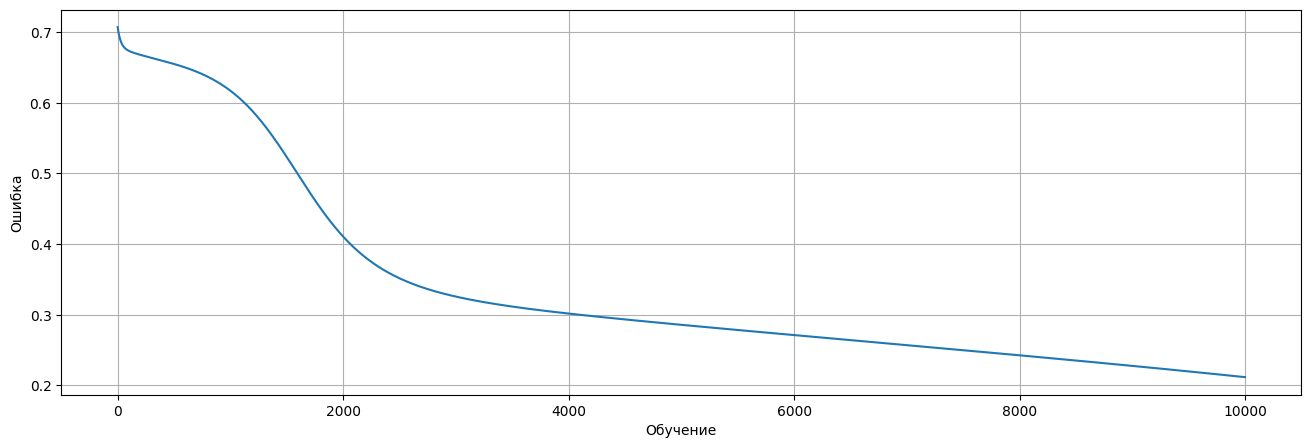

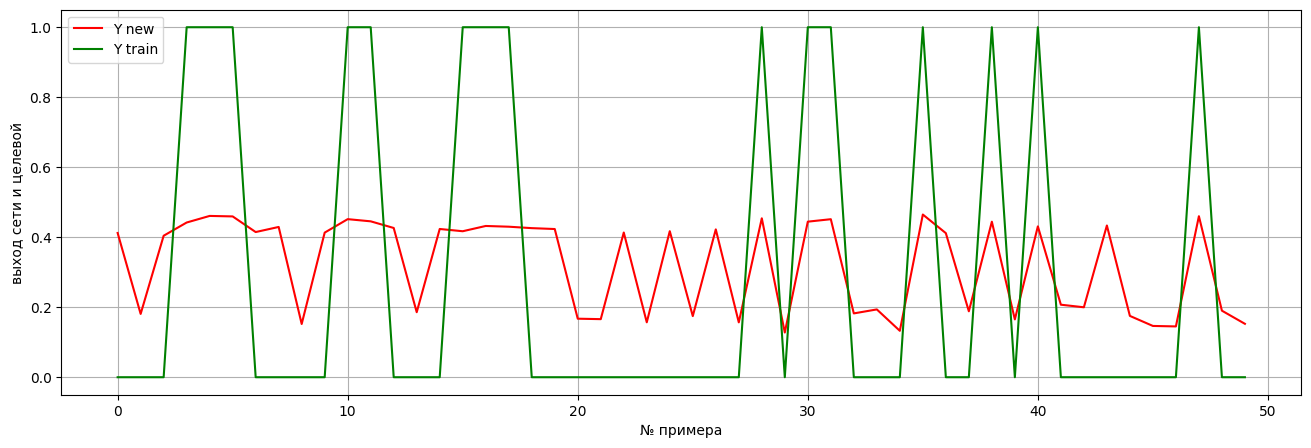

Аккуратность нейронной сети 98.0%


In [40]:
### Шаг 3. Обученние нейронной сети

# число нейронов скрытого слоя
neuron_numb = 5

w0 = 2*np.random.random((4, neuron_numb)) - 1 # для входного слоя - 4 входа, 5 выходов
w1 = 2*np.random.random((neuron_numb, 3)) - 1 # для внутреннего слоя - 5 входов, 3 выхода

lr = 0.1

errors = []

n_iters = 10000
n = X_train.shape[0]

for i in range(n_iters):
    layer0 = X_train
    layer1 = sigmoid_complex_neuron(layer0, w0)
    layer2 = sigmoid_complex_neuron(layer1, w1)
    loss = np.sum((y_train - layer2) ** 2) / n
    errors.append(loss)

    dLdlayer2 = -2 * (y_train - layer2) / n
    dlayer2dz2 = dLdlayer2 * sigmoid_deriv(layer2)
    dLdw1 = layer1.T @ dlayer2dz2
    
    dz2dlayer1 = dlayer2dz2 @ w1.T
    dlayer1dz1 = dz2dlayer1 * sigmoid_deriv(layer1)
    dLdw0 = layer0.T @ dlayer1dz1

    w0 -= lr * dLdw0
    w1 -= lr * dLdw1

layer0 = X_train
layer1 = sigmoid_complex_neuron(layer0, w0)
layer2 = sigmoid_complex_neuron(layer1, w1)

y_pred = np.argmax(layer2, axis=1)
y_train_labels = from_one_hot(y_train)
accuracy = accuracy_score(y_train_labels, y_pred) * 100

### Шаг 4. Демонстрация полученных результатов
# черчение диаграммы точности в зависимости от обучения
plt.figure(figsize = (16,5))
plt.plot(errors)
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.grid()
plt.show() # расскоментируйте, чтобы посмотреть

N = 50
plt.figure(figsize = (16,5))
plt.plot(layer2[:N,1], 'r',label = 'Y new')
plt.plot(y_train[:N,1],'g', label = 'Y train')
plt.xlabel('№ примера')
plt.ylabel('выход сети и целевой')
plt.legend( )
plt.grid()
plt.show() # расскоментируйте, чтобы посмотреть

print("Аккуратность нейронной сети " + str(round(accuracy,2)) + "%")

In [41]:
w1

array([[-1.5131854 , -1.27300168,  1.26041301],
       [ 2.89157026, -3.98011228, -3.03680109],
       [ 4.39447583,  1.09409014, -7.50229329],
       [-4.4234578 , -0.72243408,  3.78556332],
       [-3.70457111,  0.97009214,  1.60838636]])

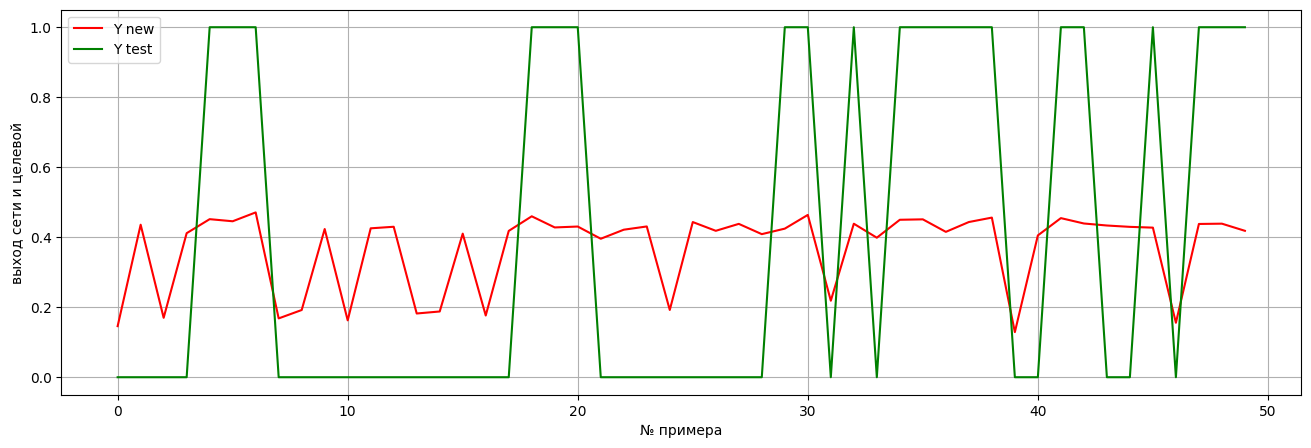

Аккуратность нейронной сети на тесте 92.0%


In [45]:
layer0_t = X_test
layer1_t = sigmoid_complex_neuron(layer0_t, w0)
layer2_t = sigmoid_complex_neuron(layer1_t, w1)

y_pred_t = np.argmax(layer2_t, axis=1)
y_test_labels = from_one_hot(y_test)

N = 50
plt.figure(figsize = (16,5))
plt.plot(layer2_t[:N,1], 'r',label = 'Y new')
plt.plot(y_test[:N,1],'g', label = 'Y test')
plt.xlabel('№ примера')
plt.ylabel('выход сети и целевой')
plt.grid()
plt.legend( )
plt.show() # расскоментируйте, чтобы посмотреть

accuracy_t = accuracy_score(y_test_labels, y_pred_t) * 100
print("Аккуратность нейронной сети на тесте " + str(round(accuracy_t,2)) + "%")

## Практическое задание

Используем набор примеров load_digits

1.  Опишите - какой результата получен в нейросети в зависимости от:
  - числа нейронов в слое(для 2-хслойной сети),
  - шага обучения в диапазоне [10.0**(-5), 10.0].
  - фиксируйте для тренировочного и тестового набора метрики accuracy.
2. Сделайте вывод - что помогло вам улучшить качество классификации в нейросети на тестовом наборе?

3. Для одного варианта сетей сформируйте матрицу ошибок по классам. Оцените качество модели по каждому классу отдельно (полнота , точность). Сделайте вывод.

In [63]:
digits = load_digits()
x = digits['data']
x.shape

(1797, 64)

In [64]:
x = normalize(x)

In [65]:
y = digits['target']
y.shape

(1797,)

In [66]:
y = to_one_hot(y)
y.shape

(1797, 10)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

class NeuralNetwork2Layers:
    def __init__(self, lr=0.05, n_iters=1000, neuron_numb=16):
        self.lr = lr
        self.n_iters = n_iters
        self.neuron_numb = neuron_numb
        self.w0 = 2*np.random.random((64, neuron_numb)) - 1 
        self.w1 = 2*np.random.random((neuron_numb, 10)) - 1

    def get_loss(self, y_pred_proba, y):
        n = y.shape[0]
        return np.sum((y - y_pred_proba) ** 2) / n

    def forward(self, x):
        layer0 = x
        layer1 = sigmoid_complex_neuron(layer0, self.w0)
        layer2 = sigmoid_complex_neuron(layer1, self.w1)
        return [layer0, layer1, layer2]

    def backward(self, layers, y):
        n = y.shape[0]
        layer0, layer1, layer2 = layers

        dLdlayer2 = -2 * (y - layer2) / n
        dlayer2dz2 = dLdlayer2 * sigmoid_deriv(layer2)
        dLdw1 = layer1.T @ dlayer2dz2
        
        dz2dlayer1 = dlayer2dz2 @ self.w1.T
        dlayer1dz1 = dz2dlayer1 * sigmoid_deriv(layer1)
        dLdw0 = layer0.T @ dlayer1dz1

        return [dLdw0, dLdw1]

    def step(self, dLdw):
        dLdw0, dLdw1 = dLdw
        self.w0 -= self.lr * dLdw0
        self.w1 -= self.lr * dLdw1
    
    def fit(self, x, y):
        errors = []

        for i in range(self.n_iters):
            layers = self.forward(x)
            loss = self.get_loss(layers[2], y)
            errors.append(loss)
            dLdw = self.backward(layers, y)
            self.step(dLdw)

        return errors

    def predict_proba(self, x):
        layers = self.forward(x)
        return layers[2]

    def predict(self, x):
        predict_proba = self.predict_proba(x)
        return np.argmax(predict_proba, axis=1)

In [87]:
param_grid = {
    'lr': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    'n_iters': [1000, 2000, 4000, 6000, 8000, 10000],
    'neuron_numb': [16, 24, 32, 40, 48, 56]
}
best_acc = [-np.inf, -np.inf]
best_errors = []
best_params = []

for lr in param_grid['lr']:
    for n_iters in param_grid['n_iters']:
        for neuron_numb in param_grid['neuron_numb']:
            model = NeuralNetwork2Layers(lr, n_iters, neuron_numb)
            errors = model.fit(X_train, y_train)
            
            y_pred_train = model.predict(X_train)
            y_train_labels = from_one_hot(y_train) 
            acc_train = accuracy_score(y_train_labels, y_pred_train) * 100

            y_pred_test = model.predict(X_test)
            y_test_labels = from_one_hot(y_test) 
            acc_test = accuracy_score(y_test_labels, y_pred_test) * 100

            if acc_test > best_acc[1] or (acc_test == best_acc[1] and acc_train > best_acc[0]):
                best_acc = [acc_train, acc_test]
                best_errors = errors
                best_params = [lr, n_iters, neuron_numb]

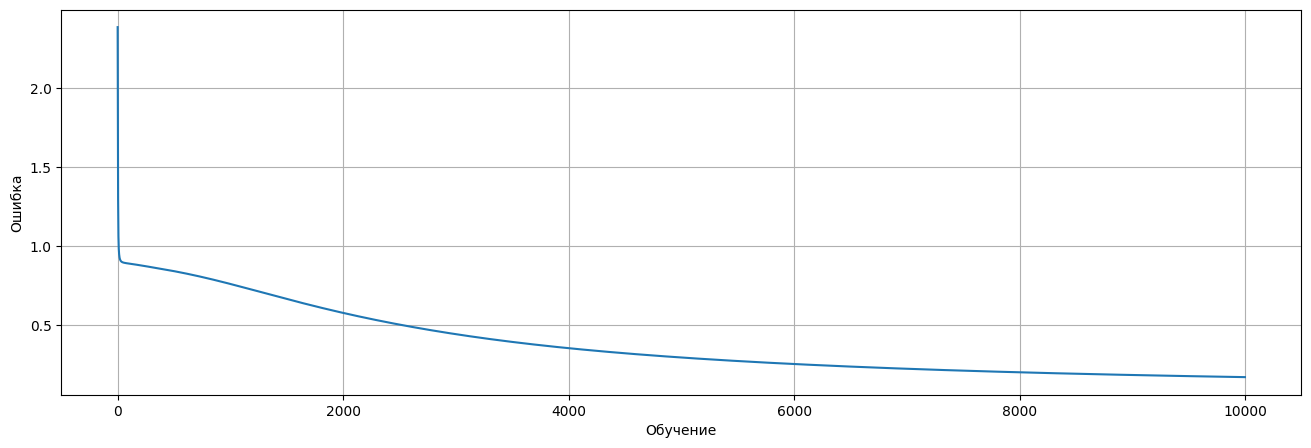

Аккуратность нейронной сети на тесте 93.94%
Аккуратность нейронной сети на трейне 95.18%
Лучшие параметры: lr=0.1, n_iters=10000, neuron_numb=56


In [89]:
plt.figure(figsize = (16,5))
plt.plot(best_errors)
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.grid()
plt.show()

print("Аккуратность нейронной сети на тесте " + str(round(best_acc[1],2)) + "%")
print("Аккуратность нейронной сети на трейне " + str(round(best_acc[0],2)) + "%")
print(f"Лучшие параметры: lr={best_params[0]}, n_iters={best_params[1]}, neuron_numb={best_params[2]}")

#### Вывод о том, что помогло улучшить качество классификации
1. Чем больше количество эпох, тем больше лосс сходится к минимуму, что улучшает точность.
2. Более агрессивный learning rate позволяет не застрять лоссу в локальных минимумах и быстрее сойтись модели.
3. Большее кол-во нейронов в скрытом слое позволяет модели учитывать больше число зависимостей во входных данных.

Для матрицы ошибок возьмём модель с наилучшими параметрами

In [93]:
best_model = NeuralNetwork2Layers(0.1, 10000, 56)
_ = best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_test_labels = from_one_hot(y_test) 

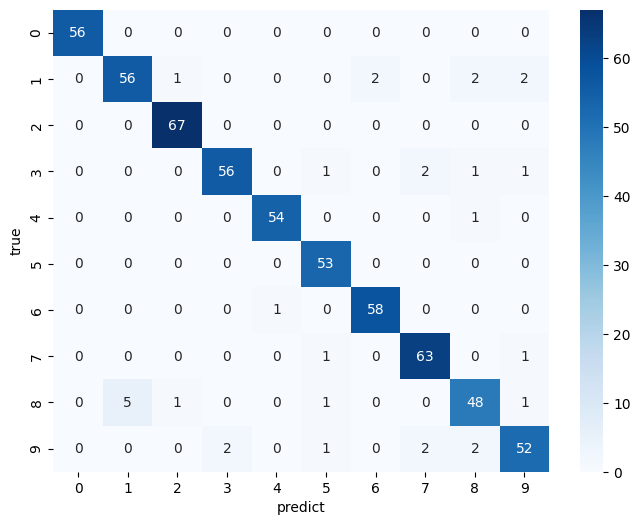

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           1       0.92      0.89      0.90        63
           2       0.97      1.00      0.99        67
           3       0.97      0.92      0.94        61
           4       0.98      0.98      0.98        55
           5       0.93      1.00      0.96        53
           6       0.97      0.98      0.97        59
           7       0.94      0.97      0.95        65
           8       0.89      0.86      0.87        56
           9       0.91      0.88      0.90        59

    accuracy                           0.95       594
   macro avg       0.95      0.95      0.95       594
weighted avg       0.95      0.95      0.95       594



In [96]:
cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('true')
plt.xlabel('predict')
plt.show()

print(classification_report(y_test_labels, y_pred))

### Вывод по качеству модели
Нейронная сеть с 1 скрытым слоем отлично справилась с задачей. Минимальный precision = 0,89 модель имеет для цифры 8,
а минимальный recall = 0,86 модель имеет для цифры 8. Значения точности и полноты для других цифр в среднем > 0,9 а матрица
ошибок по классам имеет диагональный вид. Всё это говорит о высокой точности модели для задачи предсказания цифр для датасета load_digits.

In [97]:
data = [
    431, 398, 423, 401, 423, 404, 389, 428, 402, 404,
    427, 398, 422, 409, 420, 422, 397, 458, 403, 411,
    398, 408, 438, 414, 413, 404, 426, 434, 430, 397,
    383, 415, 418, 438, 394, 417, 412, 404, 389, 398,
    431, 423, 401, 423, 435, 427, 428, 405, 414, 415,
    439, 409, 391, 416, 419, 401, 372, 395, 418, 413,
    407, 445, 428, 420, 429, 395, 433, 406, 402, 398,
    399, 432, 405, 412, 425, 417, 424, 416, 396, 403,
    432, 402, 431, 419, 423, 441, 424, 410, 424, 413,
    393, 412, 302, 408, 437, 416, 436, 415, 421, 407,
    404, 404, 403, 434, 412, 419, 405, 402, 394, 423,
    398, 415, 401, 398, 428, 416, 453, 371, 424, 417
]
len(data)

120

In [98]:
frequency = {}
for value in data:
    if value in frequency:
        frequency[value] += 1
    else:
        frequency[value] = 1

frequency = dict(sorted(frequency.items()))

print("Статистический ряд (словарь частот):")
print(frequency)

Статистический ряд (словарь частот):
{302: 1, 371: 1, 372: 1, 383: 1, 389: 2, 391: 1, 393: 1, 394: 2, 395: 2, 396: 1, 397: 2, 398: 7, 399: 1, 401: 4, 402: 4, 403: 3, 404: 6, 405: 3, 406: 1, 407: 2, 408: 2, 409: 2, 410: 1, 411: 1, 412: 4, 413: 3, 414: 2, 415: 4, 416: 4, 417: 3, 418: 2, 419: 3, 420: 2, 421: 1, 422: 2, 423: 6, 424: 4, 425: 1, 426: 1, 427: 2, 428: 4, 429: 1, 430: 1, 431: 3, 432: 2, 433: 1, 434: 2, 435: 1, 436: 1, 437: 1, 438: 2, 439: 1, 441: 1, 445: 1, 453: 1, 458: 1}


In [100]:
print(len(frequency.keys()))

56


In [101]:
print(np.floor(np.log(120) + 1))

5.0


In [105]:
keys = frequency.keys()
m = 7
intervs = np.linspace(302, 458, 8)
intervs

array([302.        , 324.28571429, 346.57142857, 368.85714286,
       391.14285714, 413.42857143, 435.71428571, 458.        ])

In [134]:
# 302, 324.29, 346.58, 368.87, 391.15, 413.44, 435.72, 458
# 1 0 0 6 52 52 9
s = 0
m = 412.95
for k in frequency: 
    s += frequency[k] * ((k - m) ** 2)
s

40643.700000000004

In [139]:
d = round(s / 120, 2)
d

338.7

In [140]:
dl = np.sqrt(d)

In [137]:
dl

18.4

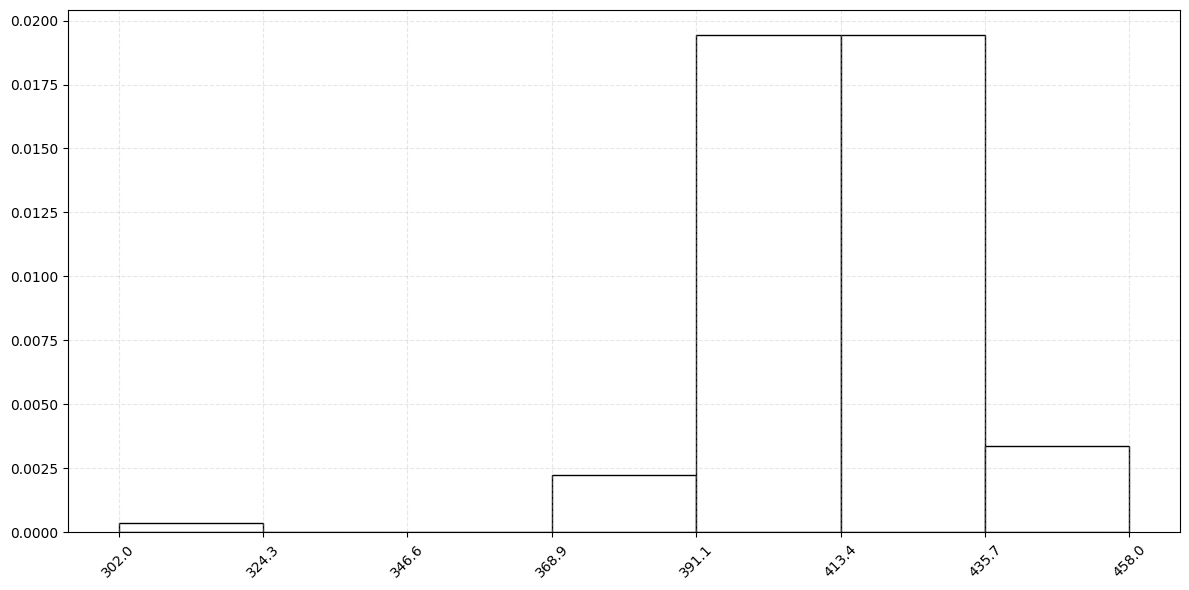

In [129]:
delta = 22.29
n = 120
boundaries = [302, 324.29, 346.58, 368.87, 391.15, 413.44, 435.72, 458]
n_i = [1, 0, 0, 6, 52, 52, 9]
f_n = [ni / (n * delta) for ni in n_i]
midpoints = [(boundaries[i] + boundaries[i+1]) / 2 for i in range(len(boundaries)-1)]

fig, ax = plt.subplots(figsize=(12, 6))

for i in range(len(n_i)):
    ax.bar(midpoints[i], f_n[i], width=delta, 
           edgecolor='black', 
           facecolor='white',
           linewidth=1)

ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xticks(boundaries)
ax.set_xticklabels([f'{b:.1f}' for b in boundaries], rotation=45)
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


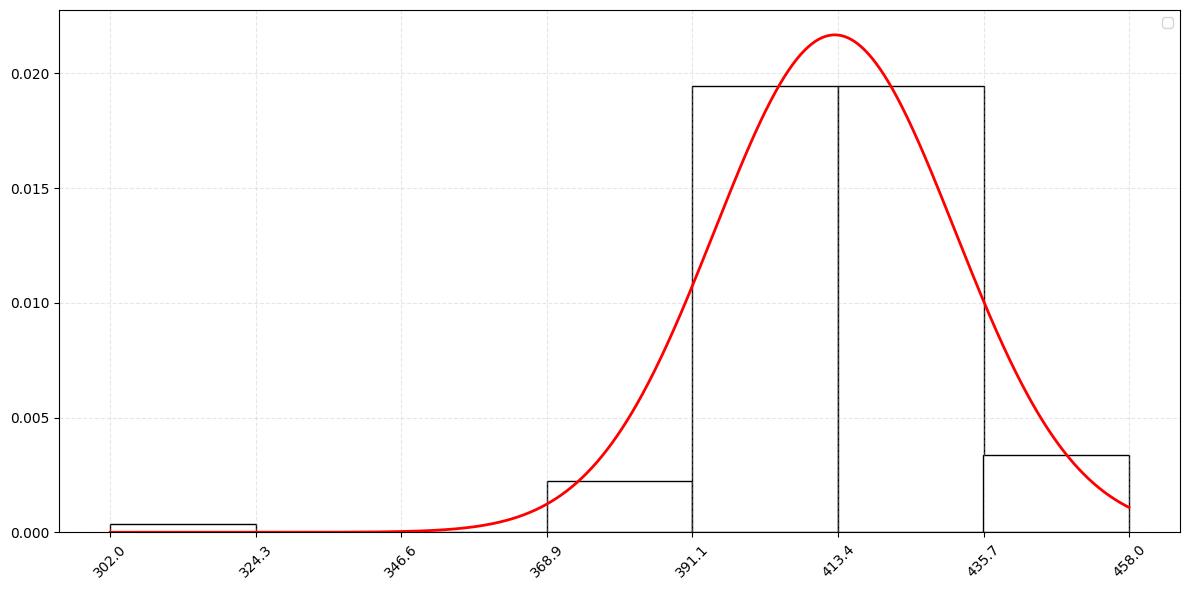

In [148]:
import numpy as np
from scipy.stats import norm

delta = 22.29
n = 120
boundaries = [302, 324.29, 346.58, 368.87, 391.15, 413.44, 435.72, 458]
n_i = [1, 0, 0, 6, 52, 52, 9]
f_n = [ni / (n * delta) for ni in n_i]
midpoints = [(boundaries[i] + boundaries[i+1]) / 2 for i in range(len(boundaries)-1)]

fig, ax = plt.subplots(figsize=(12, 6))

# Гистограмма
for i in range(len(n_i)):
    ax.bar(midpoints[i], f_n[i], width=delta, 
           edgecolor='black', 
           facecolor='white',
           linewidth=1)

# Параметры нормального распределения
mu = 412.95
sigma = 18.4

# Создаём диапазон значений для графика
x = np.linspace(boundaries[0], boundaries[-1], 1000)
# Вычисляем плотность нормального распределения
y = norm.pdf(x, mu, sigma)

# Добавляем график нормального распределения
ax.plot(x, y, 'r-', linewidth=2)

ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xticks(boundaries)
ax.set_xticklabels([f'{b:.1f}' for b in boundaries], rotation=45)
ax.legend()
plt.tight_layout()
plt.show()